# Τελική Εργασία

# Αναγνώριση Προτύπων

Ζαχάρη Βάια 58161

# **ΜΕΡΟΣ Α**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/final"
!unzip -q "/content/drive/My Drive/final_project_protupa/Mask_DB.zip" -d "/content/final"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Α)**Χωρίζουμε τα δεδομένα τυχαία σε 60% δεδομένα εκπαίδευσης, 20% δεδομένα επικύρωσης και 20% δεδομένα δοκιμής.

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import datasets
from skimage import transform
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader ,TensorDataset, random_split
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import roc_auc_score





# hyper-parameters
num_epochs = 10
batch_size = 100
learning_rate = 0.001

In [ ]:
# Συνάρτηση για τη φόρτωση εικόνων και την μετατροπή τους σε numpy arrays
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(np.array(img))
            labels.append(1 if "with_mask" in folder else 0)
    return images, labels

# Φόρτωση εικόνων από τους φακέλους
with_mask_images, with_mask_labels = load_images_from_folder('/content/final/with_mask')
without_mask_images, without_mask_labels = load_images_from_folder('/content/final/without_mask')

# Συνένωση των λιστών εικόνων και των ετικετών
all_images = np.array(with_mask_images + without_mask_images)
all_labels = np.array(with_mask_labels + without_mask_labels)

# Δημιουργία PyTorch tensors για τις εικόνες και τις ετικέτες
all_labels_tensor = torch.tensor(all_labels).long()   # Μετατροπή των ετικετών σε PyTorch tensors
# Υποθέτοντας ότι all_images είναι ένα numpy array εικόνων στη μορφή (ύψος, πλάτος, κανάλια)
all_images_transposed = all_images.transpose((0, 3, 1, 2))  # Αλλαγή σε μορφή (batch_size, κανάλια, ύψος, πλάτος)

all_images_tensor = torch.tensor(all_images_transposed).float()

# Δημιουργία ενός dataset από τους tensors
dataset = TensorDataset(all_images_tensor, all_labels_tensor)


seed = 42
torch.manual_seed(seed)

# Mεγέθη για κάθε σύνολο
total_size = len(dataset)
train_size = int(0.6 * total_size)
test_size = int(0.2 * total_size)
validation_size = total_size - train_size - test_size

# Διαίρεση του dataset σε σύνολα εκπαίδευσης, επικύρωσης και ελέγχου
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# Ορισμός των DataLoaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



**B)**
Για το συγκεκριμένο πρόβλημα ταξινόμησης εικόνων - ειδικά για την ανίχνευση χρήσης μάσκας σε πρόσωπα - η χρήση Συνελικτικών Νευρωνικών Δικτύων (Convolutional Neural Networks, CNNs) θεωρείται ιδανική. Τα CNNs είναι ιδιαίτερα δυνατά στην επεξεργασία εικόνων και αναγνώριση προτύπων μέσα σε αυτές, χάρη στην ικανότητά τους να εξάγουν χαρακτηριστικά από τις εικόνες με τη χρήση φίλτρων

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Επίπεδο 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),  # Αλλαγή από 1 σε 3
            nn.ReLU(),
            nn.MaxPool2d(2))

        # Επίπεδο 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))

        # Πλήρως συνδεδεμένο επίπεδο
        self.fc = nn.Linear(8*8*32, 2)  # Υποθέτοντας 2 κατηγορίες
        self.flatten = nn.Flatten()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

# Δημιουργία αντικειμένου CNN
cnn = CNN()


In [ ]:
print(cnn)
params = list(cnn.parameters())
print("Number of learnable parameters' sets: " , len(params))
for i in params:
  print(i.size())

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=2048, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
Number of learnable parameters' sets:  6
torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([2, 2048])
torch.Size([2])


In [ ]:
def print_shapes_hook(module, input, output):
    # Εκτύπωση του σχήματος της εξόδου κάθε επιπέδου
    print(f"{module.__class__.__name__} output shape: {output.shape}")


hook_handles = []
for layer in cnn.children():
    hook_handles.append(layer.register_forward_hook(print_shapes_hook))

# forward pass
input_tensor = torch.randn(1, 3, 32, 32)  # Υποθέτοντας ότι το μέγεθος εισόδου είναι (batch_size, channels, height, width), το πρώτο 1 είναι το batch size
output = cnn(input_tensor)

for handle in hook_handles:
    handle.remove()


Sequential output shape: torch.Size([1, 16, 16, 16])
Sequential output shape: torch.Size([1, 32, 8, 8])
Flatten output shape: torch.Size([1, 2048])
Linear output shape: torch.Size([1, 2])


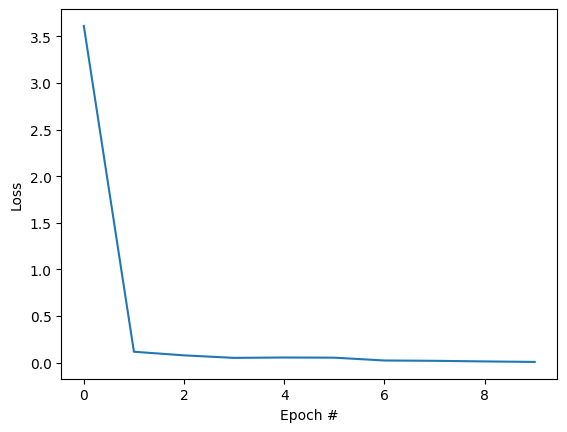

Test Accuracy of the model on the test images: 97.1223 %


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

losses = []
losses_in_epochs = []
for epoch in range(num_epochs):  # Εποχές εκπαίδευσης
    epoch_loss = 0
    num_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        losses.append(loss.item())

        if (i+1) % 100 == 0:  # Εκτύπωση πληροφοριών κάθε 100 batch
            print('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' %
                  (epoch+1, num_epochs, i+1, len(train_loader)//batch_size, loss.item()))

    # Μέση τιμή loss για την τρέχουσα εποχή
    average_loss = epoch_loss / num_batches
    losses_in_epochs.append(average_loss)

# Σχεδιάζοντας την training loss
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(losses_in_epochs)
plt.show()

# Αξιολόγηση του μοντέλου
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

# Εκτύπωση της ακρίβειας του μοντέλου στις δοκιμαστικές εικόνες
print('Test Accuracy of the model on the test images: %.4f %%' % (100 * correct / total))


Στο συγκεκριμένο διάγραμμα, μπορούμε να δούμε ότι η απώλεια ξεκινά από ένα υψηλό σημείο και μειώνεται γρήγορα μετά την πρώτη εποχή. Αυτό υποδεικνύει ότι το μοντέλο μαθαίνει και βελτιώνεται σημαντικά. Μετά τις πρώτες δύο εποχές, η μείωση της απώλειας φαίνεται να επιβραδύνεται.

Η καμπύλη της απώλειας επιπεδώνει καθώς πλησιάζουμε την έκτη εποχή, δείχνοντας ότι το μοντέλο έχει σταθεροποιηθεί και δεν βελτιώνεται περαιτέρω σημαντικά. Αυτό σημαίνει ότι το μοντέλο έχει φτάσει σε ένα σημείο όπου πρόσθετες εποχές εκπαίδευσης δεν προσφέρουν σημαντική βελτίωση, ή ότι χρειάζεται περαιτέρω ρύθμιση των παραμέτρων για να επιτευχθούν καλύτερα αποτελέσματα.



**Γ)** **CNN_2**

Το δεύτερο μοντέλο CNN_2 έχει μερικές προσθήκες σε σχέση με το πρώτο (CNN). Πρώτον, περιλαμβάνει ένα επιπλέον συνελικτικό επίπεδο, αυξάνοντας το σύνολο από δύο σε τρία, γεγονός που το καθιστά πιο ικανό στο να αναγνωρίζει περίπλοκα χαρακτηριστικά από τις εικόνες. Δεύτερον, σε κάθε συνελικτικό επίπεδο προστίθεται ένα επίπεδο dropout, το οποίο βοηθά στο να αποφεύγεται το overfitting , δηλαδή το μοντέλο να μην εξαρτάται πολύ από τα συγκεκριμένα δεδομένα εκπαίδευσης. Τρίτον, το CNN_2 χρησιμοποιεί περισσότερα φίλτρα στα συνελικτικά επίπεδα, γεγονός που του επιτρέπει να επεξεργάζεται καλύτερα τις εικόνες. Αυτές οι προσθήκες κάνουν το CNN_2 πιο ικανό και προσαρμοσμένο για πολύπλοκα σετ δεδομένων σε σχέση με το απλούστερο πρώτο μοντέλο.

In [ ]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        # Πρώτο συνελικτικό επίπεδο με dropout
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25))  # Προσθήκη Dropout

        # Δεύτερο συνελικτικό επίπεδο με dropout
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25))  # Προσθήκη Dropout

        # Τρίτο συνελικτικό επίπεδο με dropout
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Ρύθμιση του αριθμού φίλτρων
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25))  # Προσθήκη Dropout

        # Πλήρως συνδεδεμένο επίπεδο
        self.fc = nn.Linear(4*4*64, 2)  # Προσαρμογή των εισαγωγικών χαρακτηριστικών του πλήρως συνδεδεμένου επιπέδου
        self.flatten = nn.Flatten()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)  # Προσθήκη του τρίτου επιπέδου στην προώθηση
        out = self.flatten(out)
        out = self.fc(out)
        return out

# Δημιουργία αντικειμένου CNN_2
cnn_2 = CNN_2()


In [ ]:
print(cnn_2)
params = list(cnn_2.parameters())
print("Number of learnable parameters' sets: " , len(params))
for i in params:
  print(i.size())

CNN_2(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=1024, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)
Number of learnable parameters' sets:  8
torch.Size([16, 3, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 3, 3])
to

In [ ]:
# Συνάρτηση για εκτύπωση του σχήματος των επιπέδων
def print_shapes_hook(module, input, output):
    print(f"{module.__class__.__name__} output shape: {output.shape}")

hook_handles = []
for layer in cnn_2.children():
    hook_handles.append(layer.register_forward_hook(print_shapes_hook))

# forward pass
input_tensor = torch.randn(1, 3, 32, 32)  # Υποθέτοντας ότι το μέγεθος εισόδου είναι (batch_size, channels, height, width), το πρώτο 1 είναι το batch size
output = cnn_2(input_tensor)

for handle in hook_handles:
    handle.remove()


Sequential output shape: torch.Size([1, 16, 16, 16])
Sequential output shape: torch.Size([1, 32, 8, 8])
Sequential output shape: torch.Size([1, 64, 4, 4])
Flatten output shape: torch.Size([1, 1024])
Linear output shape: torch.Size([1, 2])


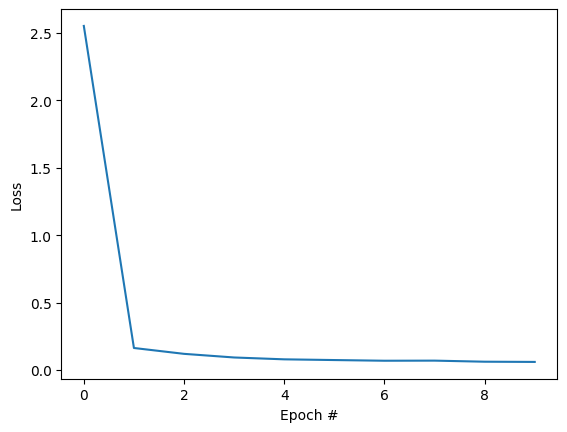

Test Accuracy of the model on the test images: 97.3621 %


In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_2.parameters(), lr=learning_rate)

# Training
losses = []
losses_in_epochs = []
for epoch in range(num_epochs):  # Επανάληψη για κάθε εποχή
    epoch_loss = 0
    num_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)


        optimizer.zero_grad()
        outputs = cnn_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        losses.append(loss.item())

        if (i+1) % 100 == 0:  # Εκτύπωση πληροφοριών κάθε 100 batch
            print('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' %
                  (epoch+1, num_epochs, i+1, len(train_loader)//batch_size, loss.item()))

    # Μέσo  loss για την τρέχουσα εποχή
    average_loss = epoch_loss / num_batches
    losses_in_epochs.append(average_loss)

# Σχεδιάζοντας  loss
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(losses_in_epochs)
plt.show()

# Αξιολόγηση του μοντέλου
cnn_2.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn_2(images)
    _, predicted = torch.max(outputs.data, 1)  #  Εύρεση της προβλεπόμενης κλάσης
    total += labels.size(0)
    correct += (predicted == labels).sum()     #  Σύγκριση με τις πραγματικές ετικέτες και υπολογισμός σωστών προβλέψεων

# Εκτύπωση της ακρίβειας του μοντέλου στις testing εικόνες
print('Test Accuracy of the model on the test images: %.4f %%' % (100 * correct / total))


Από το διάγραμμα, βλέπουμε ότι η απώλεια μειώνεται σημαντικά από την πρώτη εποχή προς την δεύτερη, υποδηλώνοντας ότι το μοντέλο έχει μάθει αποτελεσματικά από τα αρχικά στάδια της εκπαίδευσης. Μετά τις πρώτες δύο εποχές, η μείωση της απώλειας γίνεται πολύ πιο ήπια, με την καμπύλη να επιπεδώνεται. Αυτό δείχνει ότι το μοντέλο έχει φτάσει σε ένα σημείο όπου επιπλέον εκπαίδευση δεν επιφέρει σημαντικές βελτιώσεις στην απόδοσή του.



**CNN 3**

Το τρίτο μοντέλο CNN (CNN_3) χρησιμοποιεί περισσότερα φίλτρα σε κάθε συνελικτικό επίπεδο, γεγονός που του επιτρέπει να αναγνωρίζει πιο λεπτομερή χαρακτηριστικά από τις εικόνες. Έχει επίσης ενσωματωμένο batch normalization σε κάθε επίπεδο, βελτιώνοντας την εκπαίδευση και τη σταθερότητα του δικτύου. Το μοντέλο χρησιμοποιεί αυξημένα ποσοστά dropout για να μειώσει τον κίνδυνο overfitting. Επιπρόσθετα, το CNN_3 περιλαμβάνει ένα τέταρτο συνελικτικό επίπεδο για ακόμα πιο βαθιά ανάλυση και δύο πλήρως συνδεδεμένα επίπεδα, προσθέτοντας περισσότερη επεξεργαστική ικανότητα.

In [ ]:
class CNN_3(nn.Module):
    def __init__(self):
        super(CNN_3, self).__init__()
        # Πρώτο συνελικτικό επίπεδο με αύξηση φίλτρων και dropout
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Αύξηση του αριθμού φίλτρων
            nn.BatchNorm2d(32),  # Προσθήκη batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3))  # Αύξηση του ποσοστού dropout

        # Δεύτερο συνελικτικό επίπεδο με αύξηση φίλτρων και dropout
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Αύξηση του αριθμού φίλτρων
            nn.BatchNorm2d(64),  # Προσθήκη batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3))  # Αύξηση του ποσοστού dropout

        # Τρίτο συνελικτικό επίπεδο με αύξηση φίλτρων και dropout
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Αύξηση του αριθμού φίλτρων
            nn.BatchNorm2d(128),  # Προσθήκη batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4))  # Αύξηση του ποσοστού dropout

        # Προσθήκη τέταρτου συνελικτικού επιπέδου
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Αύξηση του αριθμού φίλτρων
            nn.BatchNorm2d(256),  # Προσθήκη batch normalization
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.5))  # Αύξηση του ποσοστού dropout

        # Προσθήκη επιπλέον πλήρως συνδεδεμένων επιπέδων
        self.fc1 = nn.Linear(2*2*256, 1024)  # Προσθήκη ενός επιπλέον πλήρως συνδεδεμένου επιπέδου
        self.fc2 = nn.Linear(1024, 2)  # Προσαρμογή του τελικού εξόδου σε 2 κλάσεις
        self.flatten = nn.Flatten()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Δημιουργία αντικειμένου του CNN_3
cnn_3 = CNN_3()

In [ ]:
print(cnn_3)
params = list(cnn_3.parameters())
print("Number of learnable parameters' sets: " , len(params))
for i in params:
  print(i.size())

CNN_3(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.4, inplace=False)
  )

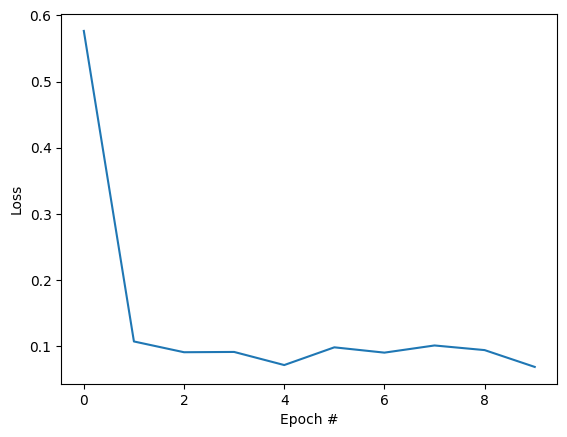

Test Accuracy of the model on the test images: 96.8825 %


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_3 .parameters(), lr=learning_rate)

# Training
losses = []
losses_in_epochs = []
for epoch in range(num_epochs):  # Επανάληψη για κάθε εποχή
    epoch_loss = 0
    num_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)


        optimizer.zero_grad()
        outputs = cnn_3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

        losses.append(loss.item())

        if (i+1) % 100 == 0:  # Εκτύπωση πληροφοριών κάθε 100 batch
            print('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f' %
                  (epoch+1, num_epochs, i+1, len(train_loader)//batch_size, loss.item()))

    # Μέσο loss για την τρέχουσα εποχή
    average_loss = epoch_loss / num_batches
    losses_in_epochs.append(average_loss)

plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(losses_in_epochs)
plt.show()

# Αξιολόγηση του μοντέλου
cnn_3.eval()  # Ορισμός του μοντέλου σε λειτουργία αξιολόγησης
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn_3(images)
    _, predicted = torch.max(outputs.data, 1)  # Εύρεση της προβλεπόμενης κλάσης
    total += labels.size(0)
    correct += (predicted == labels).sum()  # Σύγκριση με τις πραγματικές ετικέτες και υπολογισμός σωστών προβλέψεων

# Εκτύπωση της ακρίβειας του μοντέλου στις testing εικόνες
print('Test Accuracy of the model on the test images: %.4f %%' % (100 * correct / total))

Η απώλεια είναι σχετικά χαμηλή από την αρχή, ξεκινώντας κάτω από 0.8 και μειώνεται γρήγορα κατά την πρώτη εποχή. Στη συνέχεια, η μείωση της απώλειας συνεχίζεται με πιο ήπιο ρυθμό και μια ομαλότερη καμπύλη μέχρι το τέλος των εποχών που παρουσιάζονται.



Το πρώτο διάγραμμα ξεκινά με μια απώλεια περίπου 3.5 και πέφτει κατακόρυφα σε μια απώλεια κοντά στο 0 μετά από περίπου δύο εποχές. Το δεύτερο διάγραμμα ξεκινάει επίσης με υψηλή απώλεια περίπου 2.5 και πέφτει γρήγορα κάτω από 0.5 μετά την πρώτη εποχή, ενώ το τρίτο διάγραμμα έχει τη χαμηλότερη αρχική απώλεια περίπου 0.5 και μειώνεται σταθερά προς το 0.

Για να κρίνουμε ποιο διάγραμμα αντιπροσωπεύει το "καλύτερο" μοντέλο, πρέπει να λάβουμε υπόψη την απόλυτη τιμή της απώλειας καθώς και το πόσο γρήγορα και σταθερά μειώνεται αυτή με την πάροδο των εποχών. Το τρίτο διάγραμμα έχει τη χαμηλότερη αρχική απώλεια και διατηρεί μια σχετικά σταθερή μείωση, που σημαίνει πιο σταθερή εκπαίδευση και καλύτερη γενικευτική ικανότητα. Ωστόσο, το δεύτερο διάγραμμα φαίνεται να είναι εκείνο με την πιο μεγάλη βελτίωση από πολύ υψηλή απώλεια σε πολύ χαμηλή, που επίσης υποδεικνύει ένα ισχυρό μοντέλο εφόσον η χαμηλή απώλεια συντηρείται και σε νέα δεδομένα.
Άρα θεωρούμε το δεύτερο μοντέλο ως καλύτερο.

Precision-Recall AUC: 0.9933210390351699


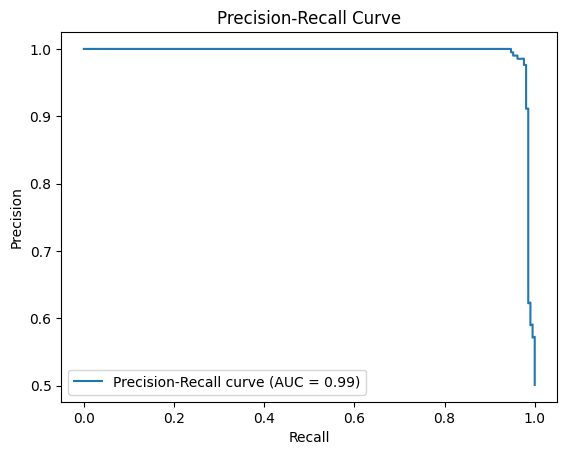

ROC AUC: 0.9893264630106736


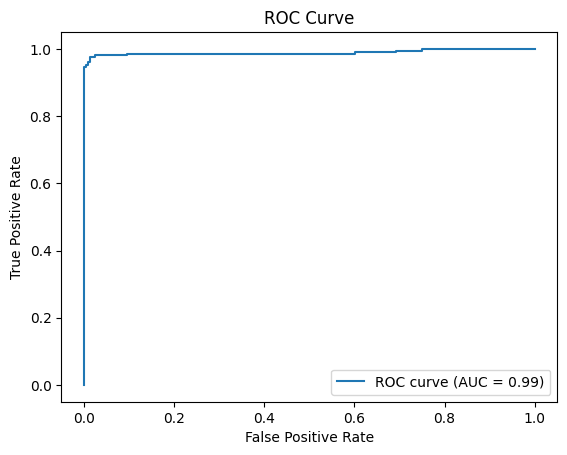

In [ ]:
# Συλλέγουμε τις ετικέτες και τις προβλέψεις
y_true = []
y_scores = []
best_cnn = cnn_2#  Δεύτερο μοντέλο

best_cnn.eval()
with torch.no_grad():  # Απενεργοποιούμε τους υπολογισμούς των gradients
    for images, labels in test_loader:
        images = images.float()
        outputs = best_cnn(images)
        #print(outputs)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Πιθανότητες για την κλάση χωρις μασκα
        y_true.extend(labels.numpy())
        y_scores.extend(probabilities.detach().numpy())

# Υπολογισμός της καμπύλης precision-recall και του AUC
precision, recall,thresholds_pr = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

# Εκτύπωση του AUC
print(f'Precision-Recall AUC: {pr_auc}')

# Σχεδίαση της καμπύλης precision-recall
plt.figure()
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Επιπλέον, αν θέλετε να υπολογίσετε και την καμπύλη ROC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Εκτύπωση του ROC AUC
print(f'ROC AUC: {roc_auc}')

# Σχεδίαση της καμπύλης ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



**ROC Curve:**

Η ROC Curve δείχνει τη σχέση μεταξύ του True Positive Rate (TPR) και του False Positive Rate (FPR) σε διάφορα κατώφλια ταξινόμησης. Μια τέλεια ταξινόμηση θα είχε μια ROC Curve που θα έφτανε στην πάνω αριστερή γωνία (TPR = 1, FPR = 0), που σημαίνει 100% ευαισθησία (sensitivity) χωρίς κανένα λάθος θετικό (false positives).

Το διάγραμμα που βλέπουμε έχει AUC (Area Under the Curve) ίσο με 1, το οποίο υποδηλώνει τέλεια απόδοση του ταξινομητή.

**Precision-Recall Curve:**

Η Precision-Recall Curve δείχνει τη σχέση μεταξύ της ακρίβειας (precision) και της ανάκλησης (recall). Η ακρίβεια είναι η πιθανότητα οι προβλέψεις που έχουν καταταγεί ως θετικές να είναι πραγματικά θετικές, ενώ η ανάκληση είναι η πιθανότητα να εντοπίσουμε όλες τις πραγματικές θετικές περιπτώσεις.
Το διάγραμμα δείχνει πάλι ένα AUC ίσο με 1, το οποίο είναι το τέλειο σκορ και μπορεί να είναι αποτέλεσμα των ίδιων συνθηκών που αναφέρθηκαν προηγουμένως.








**δ)**


Αρχικά, φορτώνουμε το dataset με τις εικόνες, στις οποίες οι μάσκες είναι φορεμένες λάθος.Στη συνέχεια, για να υπολογίσουμε το ποσοστό των εικόνων που έχουν ταξινομηθεί σε λάθος κλάση, δηλαδή σε αυτή που οι άνθρωποι φοράνε μάσκα, τρέχουμε τις εικόνες του dataset με το καλύτερο μοντέλο.

Για να μπορέσουμε έπειτα να μειώσουμε αυτό το ποσοστό, πρέπει να κάνουμε το μοντέλο πιο ευαίσθητο στη κλάση "χωρίς μάσκα", καθώς σε αυτή θα ταξινομηθούν οι εικόνες με λάθος χρήση μάσκα. Με βάση το διάγραμμα recall επέλεξα ένα threshold που μεγιστοποιεί τη τιμή recall για τη κλάση "χωρίς μάσκα".Αν η πρόβλεψη είναι πάνω από το threshold τότε θα ανήκει το δείγμα στη κλάση "χωρίς μάσκα". Με την επιλογή αυτού του threshold επιτυγχάνουμε καλύτερο recall και έτσι μειώνουμε τον αριθμό των false negatives, δηλαδή τις περιπτώσεις που το μοντέλο  ταξινομεί τα δείγματα της κλάσης "χωρίς μάσκα" στη κλάση "με μάσκα".Η τεχνική αυτή βοηθάει στο να ταξινομηθούν σωστά οι εικόνες που οι μάσκες έχουν τοποθετηθεί λανθασμένα, καθώς πλεον το μοντέλο επικεντρώνεται περισσότερο στο να εντοπίζει τις περιπτώσεις "χωρίς μάσκα".

**ΔΟΚΙΜΕΣ threshold**

Στην αρχή όταν πήρα το threshold που μεγιστοποιούσε τη recall, δηλαδή το threshold_pr[0], ενώ μηδένισε το ποσοστό των εσφαλμένων ταξινομήσεων, στο test set του μοντέλου δεν λειτούργησε καλά, καθώς το test accuracy έπεσε περίπου στο 50%. Αυτό συνέβη διότι προσπαθώντας να αυξήσω τη πιθανότητα να ταξινομηθεί μία εικόνα ως εικόνα χωρίς μάσκα, μείωνα ταυτόχρονα τη πιθανότητα να ταξινομηθεί στην κλάση με μάσκα. Υπάρχει ένα trade off μεταξύ recall και presicion. Οπότε δοκίμασα και άλλες τιμές του threshold και κατέληξα στο thresholds_pr[max_recall_index + 160]. Με αυτό το  threshold, όπως παρατηρούμε παρακάτω, η τιμή του ποσοστού εσφαλμένων ταξινομήσεων πάλι είναι ελάχιστη και η ακρίβεια του μοντέλου γενικά κρατήθηκε σε μία καλή ακρίβεια.



In [ ]:
mask_incorrect_use_images, _ = load_images_from_folder('/content/final/mask_incorrect_use')
mask_incorrect_use_images_np = np.array(mask_incorrect_use_images)
mask_incorrect_use_images = mask_incorrect_use_images_np.transpose((0, 3, 1, 2))  # Αλλαγή στη μορφή (batch_size, channels, height, width)

mask_incorrect_use_images_tensor = torch.tensor(mask_incorrect_use_images).float()


In [ ]:
# Θέτουμε το μοντέλο σε λειτουργία αξιολόγησης

best_cnn.eval()
# Απενεργοποιούμε τους υπολογισμούς των gradients για την αξιολόγηση
with torch.no_grad():
    # Προβλέψεις του μοντέλου
    outputs = best_cnn(mask_incorrect_use_images_tensor)

    # Υπολογισμός της κλάσης με την υψηλότερη πιθανότητα
    _, predicted_classes = torch.max(outputs, 1)

print(predicted_classes)
# Υπολογισμός του ποσοστού των εικόνων που ταξινομούνται εσφαλμένα ως "αποδεκτή χρήση μάσκας"
incorrectly_classified = (predicted_classes == 0).sum().item()  # Υποθέτουμε ότι η κλάση 0 είναι "με μάσκα"
total_images = mask_incorrect_use_images_tensor.size(0)

# Ποσοστό λανθασμένης ταξινόμησης
percentage_incorrectly_classified = (incorrectly_classified / total_images) * 100

print(f"Ποσοστό εσφαλμένης ταξινόμησης ως 'αποδεκτή χρήση μάσκας': {percentage_incorrectly_classified:.2f}%")


tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 0, 1, 0, 1, 1])
Ποσοστό εσφαλμένης ταξινόμησης ως 'αποδεκτή χρήση μάσκας': 19.64%


In [ ]:

max_recall_index = np.argmax(recall)
#print(thresholds_pr)
selected_threshold = thresholds_pr[max_recall_index + 160]


# Εκτυπώνουμε το threshold που δίνει το υψηλότερo recall
print(f"Το threshold που μεγιστοποιεί τη recall για τη κλάση χωρίς μάσκα είναι: {selected_threshold}")


Το threshold που μεγιστοποιεί τη recall για τη κλάση χωρίς μάσκα είναι: 0.013076506555080414


In [ ]:
threshold = selected_threshold # threshold  για την κλάση "χωρίς μάσκα"

# Υποθέτουμε ότι οι προβλέψεις του μοντέλου επιστρέφονται σε μορφή softmax probabilities
with torch.no_grad():

    outputs = best_cnn(mask_incorrect_use_images_tensor)
    probabilities = torch.softmax(outputs, dim=1)

    # Υπολογίζουμε τις προβλεπόμενες κλάσεις με βάση το κατώφλι
    predicted_classes = (probabilities[:, 1] >= threshold).long()  # Κλάση 1 εάν η πιθανότητα είναι >= threshold

print(predicted_classes)
# Υπολογισμός του ποσοστού των εικόνων που ταξινομούνται εσφαλμένα
incorrectly_classified = (predicted_classes == 0).sum().item() # Υποθέτουμε ότι η κλάση 0 είναι "με μάσκα"
total_images = mask_incorrect_use_images_tensor.size(0)

# Ποσοστό λανθασμένης ταξινόμησης
percentage_incorrectly_classified = (incorrectly_classified / total_images) * 100

print(f"Ποσοστό εσφαλμένης ταξινόμησης ως 'αποδεκτή χρήση μάσκας': {percentage_incorrectly_classified:.2f}%")


tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 1, 1])
Ποσοστό εσφαλμένης ταξινόμησης ως 'αποδεκτή χρήση μάσκας': 5.36%


Παρατηρούμε ότι το ποσοστό εσφαλμένης ταξινόμηση ως 'αποδεκτή χρήση μάσκας' έχει μειωθεί κατα πολύ. Μπορούμε να δούμε από το tensor με τα labels ότι τα περισσότερα labels ανήκουν στη σωστή κλάση, όπως ήταν αναμενόμενο.

In [ ]:
# Αξιολόγηση του μοντέλου
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images)
    # Εφαρμογή softmax για μετατροπή σε πιθανότητες
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Επιλογή της κλάσης με βάση το threshold
    predicted = (probabilities[:, 1] > threshold).long()  # Κλάση 1 (χωρίς μάσκα) εάν η πιθανότητα > threshold

    total += labels.size(0)
    correct += (predicted == labels).sum().item()


# Εκτύπωση της ακρίβειας του μοντέλου στις testing εικόνες
print('Test Accuracy του μοντέλου στις test εικόνες: %.4f %%' % (100 * correct / total))

Test Accuracy του μοντέλου στις test εικόνες: 90.6475 %


**ΔΙΑΓΡΑΜΜΑ ΑΡΧΙΤΕΚΤΟΝΙΚΗΣ του καλύτερου μοντέλου για το powerpoint**

In [ ]:
pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=33cd0d91de6e1aee46d5c25e3eb2021600bf7e8b349948acc38a2bf4611fa1cc
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
from torchviz import make_dot

sample_input = torch.randn(1,3, 32, 32)
model_output = cnn_2(sample_input)
make_dot(model_output, params=dict(list(cnn_2.named_parameters()))).render("cnn_architecture", format="png")

'cnn_architecture.png'

# **ΜΕΡΟΣ Β**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/final_2"
!unzip -q "/content/drive/My Drive/final_project_protupa/Data_Receptors.zip" -d "/content/final_2"

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE as smt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from sklearn.metrics import roc_auc_score


In [ ]:
# Ορίσμος του seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Διαβάστε τα δεδομένα από ένα αρχείο CSV
data = pd.read_csv('/content/final_2/Train_Features.csv', header=None).to_numpy()
labels = pd.read_csv('/content/final_2/Train_Labels.csv', header=None).to_numpy()

# Μετατροπή των δεδομένων σε numpy arrays
data = data.astype(np.float32)
labels = labels.astype(np.long)

smote = smt(sampling_strategy = 'minority', random_state = 42)
data_new , labels_new = smote.fit_resample(data, labels)

# Διαχωρισμός των δεδομένων σε εκπαίδευση και επικύρωση
X_train, X_val, y_train, y_val = train_test_split(data_new, labels_new, test_size=0.2, random_state=seed)

# Κανονικοποίηση δεδομένων
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Μετατροπή των δεδομένων σε tensors του PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# Μετατρέπουμε το y_train_tensor σε 1D tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long).view(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).view(-1)

<ipython-input-38-ce3532358b8c>:12: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = labels.astype(np.long)


**SMOTE METHOD**

Χρησιμοποιήσαμε τη μέθοδο SMOTE για να αντιμετωπίσει το πρόβλημα της ανισορροπίας κλάσεων σε ένα πρόβλημα ταξινόμησης, καθώς η κλάση 1 έχει περισσότερα δείγματα. Η μέθοδος SMOTE λύνει αυτό το πρόβλημα δημιουργώντας συνθετικά δείγματα για τη λιγότερο αντιπροσωπευτική κλάση. Τα συνθετικά δείγματα δημιουργούνται με βάση τα υπάρχοντα παραδείγματα της κλάσης, προσθέτοντας τυχαία παραδείγματα μεταξύ τους. Αυτή η διαδικασία ενισχύει τον αριθμό των παραδειγμάτων στη λιγότερο αντιπροσωπευτική κλάση, βελτιώνοντας την απόδοση του μοντέλου ταξινόμησης σε αυτήν την κλάση.

Η Singular Value Decomposition **(SVD)** είναι μια τεχνική στη γραμμική άλγεβρα που χρησιμοποιείται στη μείωση διαστάσεων, ενίσχυση αποδοτικότητας αλγορίθμων, και κατανόηση σημαντικών χαρακτηριστικών στα δεδομένα. Μέσω της SVD, μπορούμε να απλοποιήσουμε τα δεδομένα διατηρώντας την περισσότερη πληροφορία, να βελτιώσουμε την απόδοση των μοντέλων μηχανικής μάθησης, να διευκολύνουμε την οπτικοποίηση και να ανακαλύψουμε πολύτιμες πληροφορίες.Εδώ τη χρησιμοποιήσαμε διότι έχουμε περισσότερα features από ότι δεδομένα. Μετά τον υπολογισμό, θα βρούμε το μέγιστο πλήθος διαστάσεων που μπορεί να φτάσει ο autoencoder χωρίς να χαθεί σημαντική πληροφορία.

In [ ]:
# Υπολογισμός του SVD
U, Sigma, VT = np.linalg.svd(X_train_tensor, full_matrices=False)

# Υπολογισμός συνολικής ενέργειας των ιδιοτιμών
cumulative_energy = np.cumsum(Sigma**2) / np.sum(Sigma**2)

# Εύρεση του αριθμού διαστάσεων για να καλύψουμε το 95% της συνολικής διακύμανσης
num_components = np.argmax(cumulative_energy >= 0.95) + 1  # Προσθέτουμε 1 επειδή οι δείκτες στην Python ξεκινούν από 0

num_components, cumulative_energy[num_components-1]  # επιστρέφει τον αριθμό διαστάσεων και την καλυπτόμενη διακύμανση


(147, 0.95025617)

Στο συγκεκριμένο πρόβλημα πρόβλεψης του βαθμού πρόσδεσης χημικών μορίων σε βιολογικούς υποδοχείς, η χρήση του autoencoder μπορεί να έχει τα εξής οφέλη:

 Ο autoencoder μπορεί να εκπαιδευτεί να αναπαριστά τα χημικά μόρια σε έναν χώρο χαμηλής διάστασης, αντλώντας τα σημαντικά χαρακτηριστικά που επηρεάζουν την πρόσδεση. Αυτό μπορεί να βοηθήσει στην ανακάλυψη των κύριων παραγόντων που επηρεάζουν την αλληλεπίδραση μεταξύ των μορίων.

Επίσης, τα χαρακτηριστικά χαμηλής διάστασης που παράγονται από τον autoencoder μπορούν να χρησιμοποιηθούν ως είσοδος σε μοντέλα πρόβλεψης προσδέσεων. Αυτό μειώνει τον αριθμό των χαρακτηριστικών που πρέπει να διαχειριστούμε στο τελικό μοντέλο πρόβλεψης, μειώνοντας τον υπολογιστικό φόρτο και τον χρόνο εκπαίδευσης.

Παράλληλα, βελτιώνεται η απόδοση του μοντέλου, καθώς τα χαρακτηριστικά χαμηλής διάστασης μπορούν να είναι περισσότερο αποτελεσματικά στην πρόβλεψη του βαθμού πρόσδεσης, καθώς είναι πιο ενημερωμένοι και εστιάζουν στα σημαντικά χαρακτηριστικά.

Γενικά, η χρήση ενός autoencoder μπορεί να βελτιώσει την απόδοση του μοντέλου σας στο πρόβλημα πρόβλεψης του βαθμού πρόσδεσης, κάνοντας την ανάλυση και την προεπεξεργασία των χημικών δεδομένων πιο αποτελεσματική και ακριβή.

In [ ]:
# Καθορίζουμε την συσκευή (GPU εάν είναι διαθέσιμη, αλλιώς CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        # Κωδικοποιητής
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim),
            nn.ReLU()
        )
        # Αποκωδικοποιητής
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Συνάρτηση προώθησης: Κωδικοποιεί και αποκωδικοποιεί τα δεδομένα
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        # Συνάρτηση για την επιστροφή των encoded χαρακτηριστικών
        return self.encoder(x)


# Εκπαίδευση του Autoencoder
input_size = X_train.shape[1]
latent_size = num_components  # Μέγεθος της κρυφής αναπαράστασης
batch_size = int(num_components) # Μέγεθος δείγματος
learning_rate = 0.001  # Ρυθμός μάθησης
num_epochs = 200  # Αριθμός εποχών

# Δημιουργία του Dataset και DataLoader
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_train, dtype=torch.float32))
train_loader_lab = DataLoader(dataset=train_dataset, batch_size = batch_size, shuffle=True, pin_memory=True)

# Αρχικοποίηση του autoencoder και μεταφορά του στην καθορισμένη συσκευή
model_auto = Autoencoder(input_size, latent_size).to(device)

# Ορισμός της συνάρτησης απώλειας και του βελτιστοποιητή
criterion = nn.MSELoss()  # Η MSE είναι η τυπική συνάρτηση απώλειας
optimizer = optim.Adam(model_auto.parameters(), lr=learning_rate)  # Adam βελτιστοποιητής

# Εκπαίδευση του Autoencoder
for epoch in range(num_epochs):
    for data in train_loader_lab:
        inputs, _ = data
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = model_auto(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/200], Loss: 1.0669
Epoch [2/200], Loss: 0.9006
Epoch [3/200], Loss: 0.8586
Epoch [4/200], Loss: 0.9815
Epoch [5/200], Loss: 0.8101
Epoch [6/200], Loss: 1.1281
Epoch [7/200], Loss: 0.7332
Epoch [8/200], Loss: 0.8696
Epoch [9/200], Loss: 0.9578
Epoch [10/200], Loss: 0.7833
Epoch [11/200], Loss: 0.8519
Epoch [12/200], Loss: 0.8483
Epoch [13/200], Loss: 0.8508
Epoch [14/200], Loss: 0.9142
Epoch [15/200], Loss: 1.3768
Epoch [16/200], Loss: 1.0338
Epoch [17/200], Loss: 0.9593
Epoch [18/200], Loss: 1.0640
Epoch [19/200], Loss: 0.9341
Epoch [20/200], Loss: 1.0151
Epoch [21/200], Loss: 0.9258
Epoch [22/200], Loss: 1.1082
Epoch [23/200], Loss: 1.0373
Epoch [24/200], Loss: 1.1262
Epoch [25/200], Loss: 1.0304
Epoch [26/200], Loss: 1.1785
Epoch [27/200], Loss: 0.9216
Epoch [28/200], Loss: 0.9522
Epoch [29/200], Loss: 1.1673
Epoch [30/200], Loss: 1.0018
Epoch [31/200], Loss: 0.9165
Epoch [32/200], Loss: 1.1838
Epoch [33/200], Loss: 0.8706
Epoch [34/200], Loss: 0.7002
Epoch [35/200], Loss: 0

In [ ]:
# Ορισμός της αρχιτεκτονικής του MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)  # Πρώτο επίπεδο
        self.relu = nn.ReLU()  # Συνάρτηση ενεργοποίησης
        self.layer2 = nn.Linear(hidden_dim, output_dim)  # Δεύτερο επίπεδο

    def forward(self, x):
        x = self.layer1(x)  # Εφαρμογή πρώτου επιπέδου
        x = self.relu(x)    # Εφαρμογή ReLU
        x = self.layer2(x)  # Εφαρμογή δεύτερου επιπέδου
        return x

# Παράμετροι του μοντέλου
input_dim = num_components  # Ο αριθμός των features μετά την SVD/encoding
hidden_dim = 100  # Μέγεθος κρυφού επιπέδου
output_dim = 2  # Κλάσεις για δυαδική ταξινόμηση

# Δημιουργία μοντέλου
model = MLP(input_dim, hidden_dim, output_dim)

# Ορισμός συσκευής (CPU ή CUDA GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Μεταφορά του μοντέλου στη συσκευή
model = model.to(device)

# Ορισμός της συνάρτησης απώλειας και του optimizer
criterion = nn.CrossEntropyLoss()  # Συνάρτηση απώλειας
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ενεργοποίηση του autoencoder σε λειτουργία αξιολόγησης
model_auto.eval()

# Κωδικοποίηση δεδομένων με το autoencoder
with torch.no_grad():
    encoded_data = model_auto.encode(X_train_tensor.to(device))

# Μετατροπή των κωδικοποιημένων δεδομένων σε tensor
encoded_data_tensor = torch.tensor(encoded_data, dtype=torch.float32)

# Εκπαίδευση του μοντέλου
num_epochs = 10000  # Αριθμός εποχών
threshold_for_early_stop = 0.0000001  # Κατώφλι για early stopping
patience = 100  # Πόσες φορές περιμένουμε πριν τη διακοπή
trigger_times = 0  # Μετρητής για early stopping

best_loss = float('inf')  # Καλύτερo loss

for epoch in range(num_epochs):
    # Εκπαίδευση με τα κωδικοποιημένα δεδομένα και τις ετικέτες
    inputs = encoded_data_tensor.to(device)
    labels = y_train_tensor.to(device)


    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Έλεγχος για early stopping
    current_loss = loss.item()
    if best_loss - current_loss > threshold_for_early_stop:
        best_loss = current_loss
        trigger_times = 0  # Επαναφορά μετρητή
    else:
        trigger_times += 1
        if trigger_times >= patience:  # Έλεγχος υπομονής
            print(f"Early stopping! Epoch: {epoch}, Best Loss: {best_loss}")
            break

    if (epoch+1) % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, current_loss))


<ipython-input-45-ffa6cabc2d2c>:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoded_data_tensor = torch.tensor(encoded_data, dtype=torch.float32)


Epoch [5/10000], Loss: 0.6627
Epoch [10/10000], Loss: 0.4354
Epoch [15/10000], Loss: 0.3604
Epoch [20/10000], Loss: 0.3265
Epoch [25/10000], Loss: 0.2960
Epoch [30/10000], Loss: 0.2660
Epoch [35/10000], Loss: 0.2503
Epoch [40/10000], Loss: 0.2392
Epoch [45/10000], Loss: 0.2270
Epoch [50/10000], Loss: 0.2159
Epoch [55/10000], Loss: 0.2062
Epoch [60/10000], Loss: 0.1980
Epoch [65/10000], Loss: 0.1910
Epoch [70/10000], Loss: 0.1843
Epoch [75/10000], Loss: 0.1781
Epoch [80/10000], Loss: 0.1725
Epoch [85/10000], Loss: 0.1672
Epoch [90/10000], Loss: 0.1623
Epoch [95/10000], Loss: 0.1577
Epoch [100/10000], Loss: 0.1533
Epoch [105/10000], Loss: 0.1491
Epoch [110/10000], Loss: 0.1453
Epoch [115/10000], Loss: 0.1416
Epoch [120/10000], Loss: 0.1381
Epoch [125/10000], Loss: 0.1347
Epoch [130/10000], Loss: 0.1314
Epoch [135/10000], Loss: 0.1281
Epoch [140/10000], Loss: 0.1252
Epoch [145/10000], Loss: 0.1224
Epoch [150/10000], Loss: 0.1196
Epoch [155/10000], Loss: 0.1170
Epoch [160/10000], Loss: 0.1

**β)**

In [ ]:
# Ορισμός της αρχιτεκτονικής του MLP_2
class MLP_2(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP_2, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)  # Νέο επίπεδο
        self.relu = nn.ReLU()
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        self.dropout = nn.Dropout(0.5)  # Dropout layer

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Εφαρμογή dropout
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        return x

# Παράμετροι του μοντέλου
input_dim = num_components  #  ο αριθμός των features μετά την SVD/encoding
hidden_dim1 = 100
hidden_dim2 = 50   # Νέο μέγεθος για την δεύτερη κρυφή στοιβάδα
output_dim = 2  # 2 κλάσεις

# Δημιουργία μοντέλου
model_2 = MLP_2(input_dim, hidden_dim1, hidden_dim2, output_dim)

# Ορισμός συσκευής (CPU ή CUDA GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Μεταφορά του μοντέλου στη συσκευή
model_2 = model_2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)


# Εκπαίδευση του μοντέλου
num_epochs = 10000
threshold_for_early_stop = 0.0000001  # Κατώφλι για early stopping
patience = 100  # Πόσες φορές περιμένουμε πριν τη διακοπή
trigger_times = 0  # Μετρητής για early stopping
best_loss = float('inf')

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model_2(encoded_data_tensor)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Έλεγχος για early stopping
    current_loss = loss.item()
    if best_loss - current_loss > threshold_for_early_stop:
        best_loss = current_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping! Epoch: {epoch}, Best Loss: {best_loss}")
            break

    if (epoch+1) % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, current_loss))


Epoch [5/10000], Loss: 0.6867
Epoch [10/10000], Loss: 0.5708
Epoch [15/10000], Loss: 0.4572
Epoch [20/10000], Loss: 0.4134
Epoch [25/10000], Loss: 0.3817
Epoch [30/10000], Loss: 0.3559
Epoch [35/10000], Loss: 0.3412
Epoch [40/10000], Loss: 0.3185
Epoch [45/10000], Loss: 0.2902
Epoch [50/10000], Loss: 0.2671
Epoch [55/10000], Loss: 0.2691
Epoch [60/10000], Loss: 0.2648
Epoch [65/10000], Loss: 0.2462
Epoch [70/10000], Loss: 0.2397
Epoch [75/10000], Loss: 0.2307
Epoch [80/10000], Loss: 0.2301
Epoch [85/10000], Loss: 0.2237
Epoch [90/10000], Loss: 0.2229
Epoch [95/10000], Loss: 0.2135
Epoch [100/10000], Loss: 0.2143
Epoch [105/10000], Loss: 0.2155
Epoch [110/10000], Loss: 0.2024
Epoch [115/10000], Loss: 0.2050
Epoch [120/10000], Loss: 0.1931
Epoch [125/10000], Loss: 0.1942
Epoch [130/10000], Loss: 0.1982
Epoch [135/10000], Loss: 0.1914
Epoch [140/10000], Loss: 0.1851
Epoch [145/10000], Loss: 0.1768
Epoch [150/10000], Loss: 0.1755
Epoch [155/10000], Loss: 0.1757
Epoch [160/10000], Loss: 0.1

In [ ]:
# Ορισμός της αρχιτεκτονικής του MLP_3
class MLP_3(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(MLP_3, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        # Προσθήκη ενός ακόμη κρυφού επιπέδου
        self.layer4 = nn.Linear(hidden_dim2, hidden_dim2)
        self.dropout = nn.Dropout(0.5)  # Dropout layer


    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)  # Εφαρμογή dropout
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer4(x)  # Προσθήκη της επιπλέον κρυφής στοιβάδας
        x = self.relu(x)
        x = self.layer3(x)
        return x

# Ορισμός νέου μοντέλου
model_3 = MLP_3(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)


# Παράμετροι του μοντέλου
input_dim = num_components  #  ο αριθμός των features μετά την SVD/encoding
hidden_dim1 = 100
hidden_dim2 = 50   # Νέο μέγεθος για την δεύτερη κρυφή στοιβάδα
output_dim = 2  # 2 κλάσεις



# Ορισμός συσκευής (CPU ή CUDA GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Μεταφορά του μοντέλου στη συσκευή
model_3 = model_3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)


# Εκπαίδευση του μοντέλου
num_epochs = 10000
threshold_for_early_stop = 0.0000001  # Κατώφλι για early stopping
patience = 100  # Πόσες φορές περιμένουμε πριν τη διακοπή
trigger_times = 0  # Μετρητής για early stopping
best_loss = float('inf')

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model_3(encoded_data_tensor)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # Έλεγχος για early stopping
    current_loss = loss.item()
    if best_loss - current_loss > threshold_for_early_stop:
        best_loss = current_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping! Epoch: {epoch}, Best Loss: {best_loss}")
            break

    if (epoch+1) % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, current_loss))


Epoch [5/10000], Loss: 0.6328
Epoch [10/10000], Loss: 0.5037
Epoch [15/10000], Loss: 0.4728
Epoch [20/10000], Loss: 0.4184
Epoch [25/10000], Loss: 0.4059
Epoch [30/10000], Loss: 0.3785
Epoch [35/10000], Loss: 0.3420
Epoch [40/10000], Loss: 0.3214
Epoch [45/10000], Loss: 0.3042
Epoch [50/10000], Loss: 0.3133
Epoch [55/10000], Loss: 0.2807
Epoch [60/10000], Loss: 0.2695
Epoch [65/10000], Loss: 0.2707
Epoch [70/10000], Loss: 0.2646
Epoch [75/10000], Loss: 0.2451
Epoch [80/10000], Loss: 0.2366
Epoch [85/10000], Loss: 0.2155
Epoch [90/10000], Loss: 0.2184
Epoch [95/10000], Loss: 0.2176
Epoch [100/10000], Loss: 0.2135
Epoch [105/10000], Loss: 0.2063
Epoch [110/10000], Loss: 0.1869
Epoch [115/10000], Loss: 0.1813
Epoch [120/10000], Loss: 0.1851
Epoch [125/10000], Loss: 0.1760
Epoch [130/10000], Loss: 0.1714
Epoch [135/10000], Loss: 0.1746
Epoch [140/10000], Loss: 0.1691
Epoch [145/10000], Loss: 0.1625
Epoch [150/10000], Loss: 0.1533
Epoch [155/10000], Loss: 0.1486
Epoch [160/10000], Loss: 0.1

Το καλύτερο MLP μοντέλο είναι το 3, καθώς έχει από τα μικρότερα losses σε λιγότερες εποχές. Το πρώτο μοντέλο, ενώ είχε το πιο μικρό loss χρειάζεται περίπου τις διπλάσιες εποχές.
Η αρχιτεκτονική του δικτύου αποτελείται από δύο κρυφά επίπεδα και ένα επιπλέον κρυφό επίπεδο που έχει προστεθεί ως επέκταση. Το μοντέλο ξεκινά με μια είσοδο διάστασης 151, που αντιπροσωπεύει τα χαρακτηριστικά μετά την εφαρμογή SVD ή κωδικοποίησης. Η πρώτη κρυφό layer έχει 100 νευρώνες, ενώ το δεύτερο και το πρόσθετο κρυφό layer έχουν από 50 νευρώνες. Το δίκτυο βγάζει έξοδο για δύο κλάσεις.

Στο forward pass, το μοντέλο εφαρμόζει τη συνάρτηση ενεργοποίησης ReLU και το dropout με πιθανότητα 0.5, που βοηθά στην αποφυγή του overfitting επιβάλλοντας μια μορφή τυχαιότητας κατά την εκπαίδευση. Το μοντέλο εκπαιδεύεται με βάση τη συνάρτηση απώλειας CrossEntropyLoss, και χρησιμοποιεί τον αλγόριθμο βελτιστοποίησης Adam με ρυθμό μάθησης 0.001. Η διαδικασία εκπαίδευσης περιλαμβάνει ένα σύστημα early stopping, το οποίο διακόπτει την εκπαίδευση εάν δεν παρατηρηθεί βελτίωση στην απώλεια για έναν ορισμένο αριθμό εποχών (epochs), που ορίζεται εδώ ως patience. Αυτό είναι ένα σημαντικό χαρακτηριστικό που βοηθά στην αποφυγή χρόνου και πόρων σε μη παραγωγικές εκπαιδευτικές περιόδους και συμβάλλει στην αποτροπή του overfitting.

**γ)**

Εφαρμόζουμε k-fold cross validation, η οποία βοηθά στη μείωση της προκατάληψης στις εκτιμήσεις απόδοσης, ενώ εξασφαλίζει ότι το μοντέλο δεν υπερπροσαρμόζεται σε συγκεκριμένο σύνολο δεδομένων, αυξάνοντας έτσι την ικανότητά του να γενικεύει σε νέα δεδομένα.

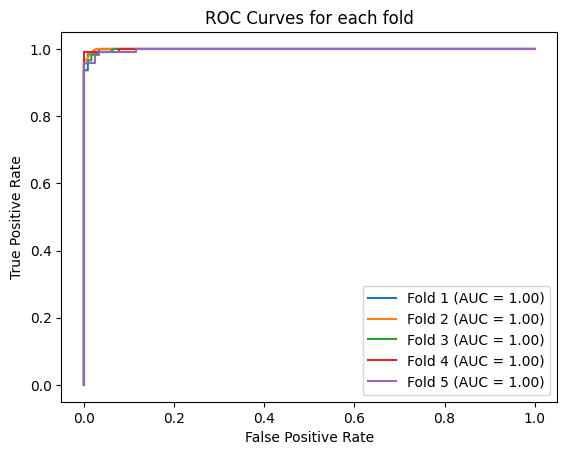

Mean accuracy over 5-folds: 0.980590717299578


In [ ]:
# Ορισμός του αριθμού των folds
n_splits = 5
kf = KFold(n_splits=n_splits)


# Αρχικοποίηση της λίστας για την αποθήκευση των scores της ακρίβειας
accuracy_scores = []
# Αρχικοποίηση λιστών για τις τιμές FPR, TPR και AUC
fprs, tprs, aucs = [], [], []

for train_index, test_index in kf.split(encoded_data_tensor):
    # Δημιουργία train και validation sets
    X_train, X_val = encoded_data_tensor[train_index], encoded_data_tensor[test_index]
    y_train, y_val = labels[train_index], labels[test_index]

    # Εκπαίδευση του μοντέλου για κάθε fold
    for epoch in range(num_epochs):
        model_3.train()
        optimizer.zero_grad()
        outputs = model_3(X_train.to(device))
        loss = criterion(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

        # Έλεγχος για early stopping
        current_loss = loss.item()
        if best_loss - current_loss > threshold_for_early_stop:
            best_loss = current_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                break  # Early stopping

# Αξιολόγηση του μοντέλου στο validation set
    model_3.eval()
    with torch.no_grad():
        val_outputs = model_3(X_val.to(device))
        val_probabilities = torch.sigmoid(val_outputs)[:, 1]
        fpr, tpr, _ = roc_curve(y_val.cpu().numpy(), val_probabilities.cpu().numpy())
        auc_score = roc_auc_score(y_val.cpu().numpy(), val_probabilities.cpu().numpy())
        _, predicted_labels = torch.max(val_outputs, 1)
        acc = accuracy_score(y_val.cpu().numpy(), predicted_labels.cpu().numpy())

        # Προσθήκη των αποτελεσμάτων στις λίστες
        accuracy_scores.append(acc)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc_score)

# Δημιουργία των διαγραμμάτων ROC για κάθε fold
for i in range(n_splits):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1} (AUC = {aucs[i]:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for each fold')
plt.legend(loc='lower right')
plt.show()

# Υπολογισμός μέσης ακρίβειας
mean_accuracy = np.mean(accuracy_scores)
print(f"Mean accuracy over {n_splits}-folds: {mean_accuracy}")

Από τα παραπάνω παρατηρούμε ότι η μέση ακρίβεια είναι 0.98 και πως οι τιμές auc είναι πολύ υψηλές, δείχνοντας έτσι τη καλή απόδοση του μοντέλου.

In [ ]:
# Φόρτωση του αρχείου CSV που περιέχει τα test features
test_features_path = '/content/final_2/Test_Features.csv'
test_data = pd.read_csv(test_features_path, header=None)


# Μετατροπή των δεδομένων σε numpy arrays και προεπεξεργασία με StandardScaler
test_data_np = test_data.values.astype(np.float32)
scaler = StandardScaler()
test_data_np = scaler.fit_transform(test_data_np)

# Μετατροπή των δεδομένων σε tensors του PyTorch
test_data_tensor = torch.tensor(test_data_np, dtype=torch.float32).to(device)

# Αξιολόγηση του autoencoder στο test set για την εξαγωγή χαρακτηριστικών χαμηλότερης διάστασης
model_auto.eval()
with torch.no_grad():
    encoded_test_data = model_auto.encode(test_data_tensor)

# Προβλέψεις με το μοντέλο ταξινόμησης
model_3.eval()
with torch.no_grad():
    test_outputs = model_3(encoded_test_data)
    test_probabilities = torch.sigmoid(test_outputs)[:, 1]
    # print(test_probabilities)
    _, predicted_labels = torch.max(test_outputs, 1)

# Καταγραφή των προβλέψεων και σκορ σε DataFrame
predicted_labels_np = predicted_labels.cpu().numpy()
test_probabilities_np = test_probabilities.cpu().numpy()
predictions_df = pd.DataFrame({
    'predicted_label': predicted_labels_np,
    'prediction_score': test_probabilities_np
})

# Αποθήκευση σε CSV
output_csv_path = '/content/final_2/test_predictions.csv'
predictions_df.to_csv(output_csv_path, index=False)


Στη γραμμή test_probabilities = torch.sigmoid(test_outputs)[:, 1], χρησιμοποιούμε τη σιγμοειδή συνάρτηση για να μετατρέψει τις πρώτες εξόδους, πριν εφαρμοστεί η συνάρτηση ενεργοποίησης, σε πιθανότητες. Επιλέγοντας τη δεύτερη στήλη ([:, 1]), λαμβάνουμε την πιθανότητα το δείγμα να ανήκει στην κλάση 1. Έτσι, το "prediction score"  είναι ουσιαστικά αυτή η πιθανότητα. Αν η τιμή είναι κοντά στο 1, το μοντέλο είναι πολύ σίγουρο ότι το δείγμα ανήκει στην κλάση 1. Αντίστοιχα, μια τιμή κοντά στο 0 σημαίνει ότι το μοντέλο είναι πολύ σίγουρο ότι το δείγμα δεν ανήκει στην κλάση 1.

**Γενικό Σχόλιο**

Γενικά, τα αποτελέσματα μπορεί να διαφέρουν σε κάθε run, δεν μπόρεσα να το αλλάξω. Για αυτό, πχ σε αυτό το run φαίνεται ότι το MLP_3 έχει λίγο παραπάνω loss.